Stock Data Analsysis 
-------------------- 
0. using alpha vantage api for getting info 
    - download data in csv format in 'prices' directory
    
1. read data from downloaded csv & save it to memory 
    - using hash table (python dictionary) on first layer because they can be easily combined across clusters. make symbol as a key.
    
2. computing averages 
    - avg (closing price of all stocks) over all time period
    - avg (volume) for each stock over.. 
    - avg(close - open price) for each stock over .. 
    - avg(high - low price) for each stock over.. 
3. the most traded stock each day , create a data structure that stores dates & stock symbols that were most traded on that day. see what company is hot. 맨날 똑같은 회사가 탑인데 의미가 있나..? 
    
4. which stocks would have been the most profitable to buy on the specific date? considering inflation
5. what stocks whould have been best to short at the start of the period? (*공매도를 하는게 좋았다는 말은 계속 떨어졌다는 말) 

6. does technical indicators really help predicting trades market? (bollinger bands - brands) 

7. based on price, what was the optimal day to buy each stock, if we wanted to hold them util now?  

## 1. read data from csv and load on to the memory 

In [1]:
import concurrent.futures
import os 
import cProfile
import time
import numpy as np

multi thread를 사용하여 파일을 읽는다. 이번 프로젝트는 여러 cluster에서 작업 하는 것을 전제로 두기 때문에 `pandas.DataFrame`이 아니라 python에 기본으로 구현되어 있는 data structure을 사용한다. 

In [2]:
def readfile(filename):
    symbol = filename.split('_')[0]
    rows = []
    try:
        with open('../prices/'+filename) as f:
            rows = f.read().strip()
            rows = rows.split('\n')
            rows = [line.split(',') for line in rows]
    except Exception as e:
        print('read file error')
    return symbol, rows 

p = concurrent.futures.ThreadPoolExecutor(max_workers=4)
filenames = [f for f in os.listdir('../prices') if f.endswith(".csv")]

profile_string = "prices = p.map(readfile, filenames)"
cProfile.run(profile_string)

         13705 function calls in 0.047 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.047    0.047 <string>:1(<module>)
      798    0.001    0.000    0.004    0.000 _base.py:312(__init__)
        1    0.000    0.000    0.047    0.047 _base.py:550(map)
        1    0.001    0.001    0.047    0.047 _base.py:575(<listcomp>)
        4    0.000    0.000    0.000    0.000 _weakrefset.py:81(add)
      798    0.002    0.000    0.019    0.000 queue.py:115(put)
      798    0.000    0.000    0.000    0.000 queue.py:206(_put)
      798    0.002    0.000    0.046    0.000 thread.py:114(submit)
      798    0.001    0.000    0.020    0.000 thread.py:127(_adjust_thread_count)
      798    0.000    0.000    0.000    0.000 thread.py:45(__init__)
        4    0.000    0.000    0.000    0.000 threading.py:1120(daemon)
        4    0.000    0.000    0.000    0.000 threading.py:1136(daemon)
        4    0.000

In [3]:
prices = dict(list(prices))

## 2. computing averages
- avg (closing price of all stocks) over all time period
- avg (volume) for each stock over all time period
- avg(close - open price) for each stock over all time period
- avg(high - low price) for each stock over all time period

change `prices` data structure columnwise so that compuatation average on each column is fast

In [4]:
# transform
from dateutil.parser import parse
prices_columnwise = {}
for k,v in prices.items():
    price = v
    headers = price[0]
    price_columns = {}
    for i, header in enumerate(headers):
        values = [p[i] for p in price[1:]]
        if i > 0:
            values = [float(v) for v in values]
        else:
            values = [parse(v) for v in values]
        price_columns[header] = values
    prices_columnwise[k] = price_columns

In [5]:
from statistics import mean 

# average closing price 
avg_closing = {}
# average volume
avg_volume = {}
# average (close-open) 
avg_diff_clos_open = {}
# average (high -low)
avg_dff_high_low = {}

for k, v in prices_columnwise.items():
    avg_closing[k] = mean(v['close'])
    avg_volume[k] = mean(v['volume'])
    avg_diff_clos_open[k] = mean([i-j for i, j in zip(v['close'], v['open'])])
    avg_dff_high_low[k] = mean([i-j for i, j in zip(v['high'],v['low'])])

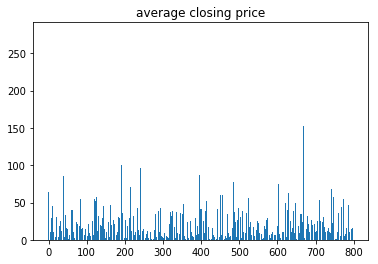

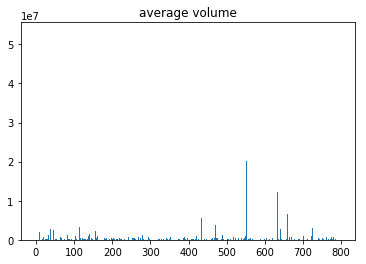

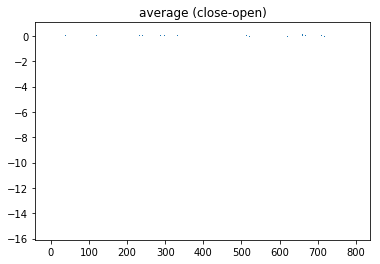

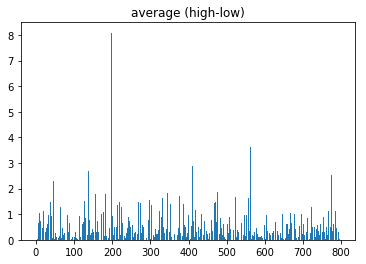

In [6]:
import matplotlib.pyplot as plt 
plt.bar(range(len(avg_closing.keys())), list(avg_closing.values()))
plt.title('average closing price')
plt.show()

plt.bar(range(len(avg_volume.keys())), list(avg_volume.values()))
plt.title('average volume')
plt.show()

plt.bar(range(len(avg_diff_clos_open.keys())), list(avg_diff_clos_open.values()))
plt.title('average (close-open)')
plt.show()

plt.bar(range(len(avg_dff_high_low.keys())), list(avg_dff_high_low.values()))
plt.title('average (high-low)')
plt.show()

## 3. the most traded stock each day
create a data structure that stores dates & stock symbols that were most traded on that day. see what company is hot.

In [9]:
trades = {}
for k, v in prices_columnwise.items():
    for i, date in enumerate(v['timestamp']):
        if date not in trades:
            trades[date] = []
        trades[date].append([k, v['volume'][i]])
         
most_traded = []
for k, v in trades.items():
    ordered = sorted(v, key=lambda x: x[1])
    most_traded.append([k, ordered[-1][0]])

In [17]:
most_traded[:5]

[[datetime.datetime(2018, 4, 6, 0, 0), 'aapl'],
 [datetime.datetime(2018, 4, 5, 0, 0), 'czr'],
 [datetime.datetime(2018, 4, 4, 0, 0), 'aapl'],
 [datetime.datetime(2018, 4, 3, 0, 0), 'intc'],
 [datetime.datetime(2018, 4, 2, 0, 0), 'intc']]

## High Volume Days

In [28]:
daily_volumes = {}

most_traded = []
for timestamp, volumes in trades.items():
    volume = sum([item[1] for item in volumes])
    daily_volumes[timestamp] = volume 

In [29]:
volume_tuples = [[k, v] for k, v in daily_volumes.items()]
volume_tuples = sorted(volume_tuples, key=lambda x:x[1], reverse=True)

In [30]:
volume_tuples[:10]

[[datetime.datetime(2012, 5, 15, 0, 0), 2626232726.0],
 [datetime.datetime(2013, 1, 11, 0, 0), 2373939004.0],
 [datetime.datetime(2013, 2, 8, 0, 0), 2345675364.0],
 [datetime.datetime(2009, 9, 22, 0, 0), 1860850139.0],
 [datetime.datetime(2013, 1, 9, 0, 0), 1841998828.0],
 [datetime.datetime(2013, 2, 7, 0, 0), 1836299981.0],
 [datetime.datetime(2013, 1, 14, 0, 0), 1688377321.0],
 [datetime.datetime(2009, 6, 3, 0, 0), 1592050146.0],
 [datetime.datetime(2009, 9, 21, 0, 0), 1580733435.0],
 [datetime.datetime(2009, 5, 29, 0, 0), 1546578236.0]]

In [64]:
import math 

high_volume_days = [v[0] for v in volume_tuples[:10]]

def binary_search(array, search):
    m = 0
    i = 0
    z = len(array)-1
    while i <= z:
        m = math.floor(i + ((z-i)/2))
        if array[m]-search==0:
            return m 
        elif array[m] < search:
            i = m + 1
        elif array[m] > search:
            z = m - 1
    return None 

In [83]:
high_volume_days

[datetime.datetime(2012, 5, 15, 0, 0),
 datetime.datetime(2013, 1, 11, 0, 0),
 datetime.datetime(2013, 2, 8, 0, 0),
 datetime.datetime(2009, 9, 22, 0, 0),
 datetime.datetime(2013, 1, 9, 0, 0),
 datetime.datetime(2013, 2, 7, 0, 0),
 datetime.datetime(2013, 1, 14, 0, 0),
 datetime.datetime(2009, 6, 3, 0, 0),
 datetime.datetime(2009, 9, 21, 0, 0),
 datetime.datetime(2009, 5, 29, 0, 0)]

In [79]:
high_volume_txs = {}
for sym, data in prices_columnwise.items():
    for day in high_volume_days:
        try:
            idx = data['timestamp'].index(day)
            if sym not in high_volume_txs:
                high_volume_txs[sym] = []
            high_volume_txs[sym].append(prices[sym][idx])
        except ValueError as e:
            pass

## 4. The most profitable to buy on 2012-01-01? 
which stocks would have been the most profitable to buy on the specific date? considering inflation

In [23]:
most_profitable = []
inflation_rate = 1.78
for k, v in prices_columnwise.items():
    percentage = (v['close'][-1]-
                  (v['close'][0]*inflation_rate))/v['close'][0]
    most_profitable.append([k, percentage*100])

# ascending order
most_profitable = sorted(most_profitable, key=lambda x:x[1], reverse=True)

In [25]:
most_profitable[:10]

[['evep', 11532.05917159763],
 ['idxg', 9706.782608695652],
 ['jasnw', 8221.999999999998],
 ['bvsn', 8049.391304347826],
 ['evlv', 5984.365591397849],
 ['cytx', 3996.067495559503],
 ['jagx', 3547.2747252747254],
 ['acerw', 3422.0],
 ['gevo', 3397.467594606351],
 ['gigm', 3022.0000000000005]]

## 5. Stocks would have been best to short at the start of the period
what stocks whould have been best to short at the start of the period? (*공매도를 하는게 좋았다는 말은 계속 떨어졌다는 말) 

In [2]:
import os
path = os.path.join('prices','function')

In [3]:
path+"/"

'prices/function/'